# Project: Prepayment Modelling

In this Jupyter Notebook is presented a data analysis for a mortgage pool. IT contains different variables as age loan, outstanding balance, client rate, refinancing rate, among other. The purpose of the project is illustrate how to develop a model for the behavior of the prepayment rate.

First is necessary to import basics libraries for data wranglig, such as pandas, numpy, etc.

In [21]:
# -*- coding: utf-8 -*-
"""
Created on Thu Oct 24 12:59:10 2024

@author: mcontreras
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler
from datetime import datetime

## 1. Reading Data

The second step consist in read the data which is read from a public GitHub.

In [22]:
url_mort = "https://raw.githubusercontent.com/macontreras04/cpf/main/mortgage_data.xlsx"

url_refr = "https://raw.githubusercontent.com/macontreras04/cpf/main/refinancing_rate_data.xlsx"



data_mort= pd.read_excel(url_mort)

data_mort['Date']=pd.to_datetime(data_mort['Date'],errors='coerce')



data_refr = pd.read_excel(url_refr)

data_refr['Date']=pd.to_datetime(data_refr['Date'],errors='coerce')

After that, the nest section is regarding combine the two dataset.

In [23]:
df =pd.merge(data_mort,data_refr,how='left',on='Date')


df['Date']= df['Date'].apply(lambda x:pd.to_datetime(x))

#df.to_excel('data_prep.xlsx', index=False)

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Group by month and calculate the average prepayment rate across all clients for each month
monthly_prepayment_rate = df.groupby(df['Date'].dt.to_period('M'))['PP_rate (%)'].mean().reset_index()

print(monthly_prepayment_rate.head())

      Date  PP_rate (%)
0  2016-01     0.003758
1  2016-02     0.004314
2  2016-03     0.004045
3  2016-04     0.004846
4  2016-05     0.007264


## 3. Plotting the monthly aggregated Prepayment

For this section,  a monthly prepayment is summarized by means for eac cliente, and plotted over the time.

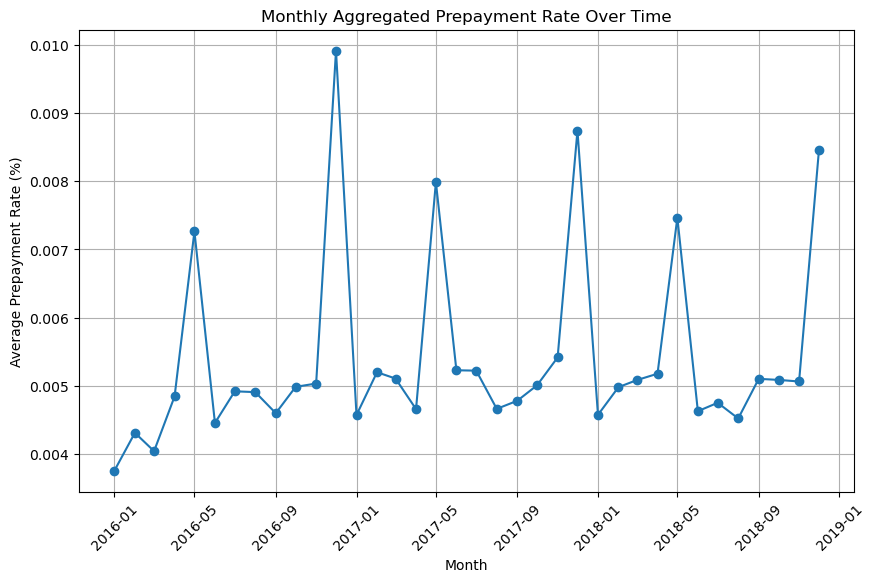

In [24]:
# Convert the period back to a datetime format for plotting
monthly_prepayment_rate['Date'] = monthly_prepayment_rate['Date'].dt.to_timestamp()


# Group by month and calculate the average refinancing rate across all clients for each month
monthly_refinancing_rate = df.groupby(df['Date'].dt.to_period('M'))['Refinancing rate'].mean().reset_index()

# Convert the period back to a datetime format for plotting
monthly_refinancing_rate['Date'] = monthly_refinancing_rate['Date'].dt.to_timestamp()



# Creating a new column for the difference between 'Client Rate' and 'Refinancing rate'
df['Refinancing Incentive'] = df['Client_rate (%)'] - df['Refinancing rate']


df.to_excel('data_prep.xlsx', index=False)


# Plotting the monthly aggregated prepayment rate


plt.figure(figsize=(10, 6))
plt.plot(monthly_prepayment_rate['Date'], monthly_prepayment_rate['PP_rate (%)'], marker='o', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Average Prepayment Rate (%)')
plt.title('Monthly Aggregated Prepayment Rate Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

We can observe from the chart above that there is a cyclical trend. Every May and December the prepayment reached a peak. In contranst, every Quarter (excep at December) the prepayment decreses

## Plotting the Refinancing Rate next to the PRepayment Rate


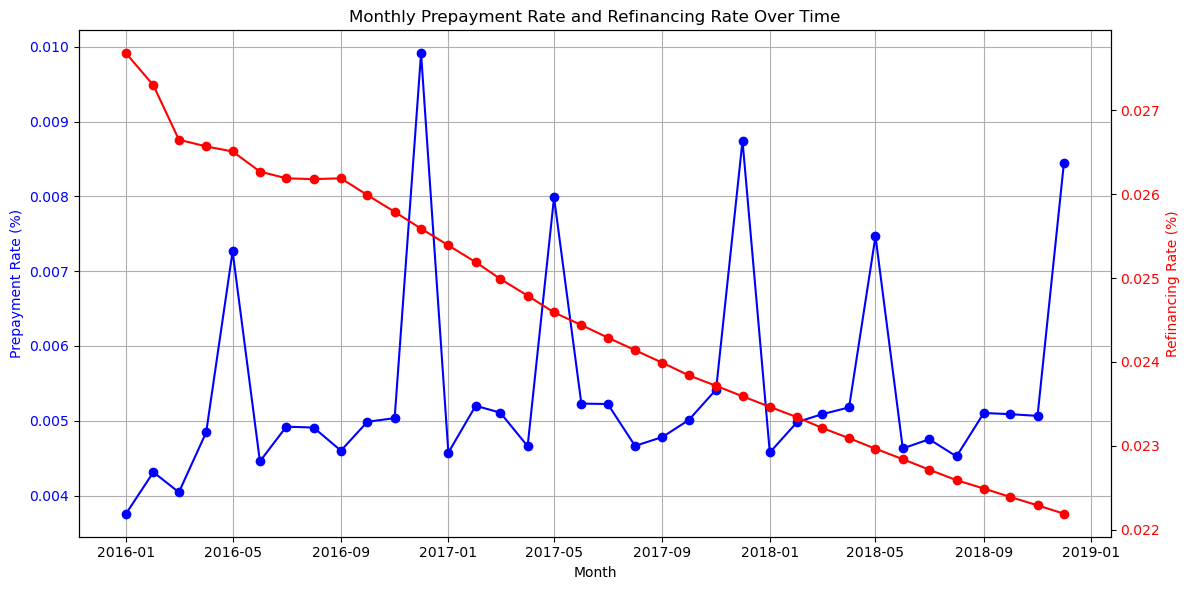

In [25]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Group by month and calculate the average prepayment rate and refinancing rate for each month
monthly_data = df.groupby(df['Date'].dt.to_period('M')).agg({
    'PP_rate (%)': 'mean',
    'Refinancing rate': 'mean'
}).reset_index()

# Convert the period back to datetime format for plotting
monthly_data['Date'] = monthly_data['Date'].dt.to_timestamp()

# Plotting the monthly prepayment rate and refinancing rate together with independent scales
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting the prepayment rate on the primary y-axis
ax1.plot(monthly_data['Date'], monthly_data['PP_rate (%)'], marker='o', linestyle='-', color='blue', label='Prepayment Rate (%)')
ax1.set_xlabel('Month')
ax1.set_ylabel('Prepayment Rate (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Monthly Prepayment Rate and Refinancing Rate Over Time')

# Creating a secondary y-axis for the refinancing rate
ax2 = ax1.twinx()
ax2.plot(monthly_data['Date'], monthly_data['Refinancing rate'], marker='o', linestyle='-', color='red', label='Refinancing Rate (%)')
ax2.set_ylabel('Refinancing Rate (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Adding grid and adjusting the layout
ax1.grid(True)
fig.tight_layout()
plt.show()

On the chart displayed above we can see that the refinancing rate has a negative slope split the prepayment rate in two groups...

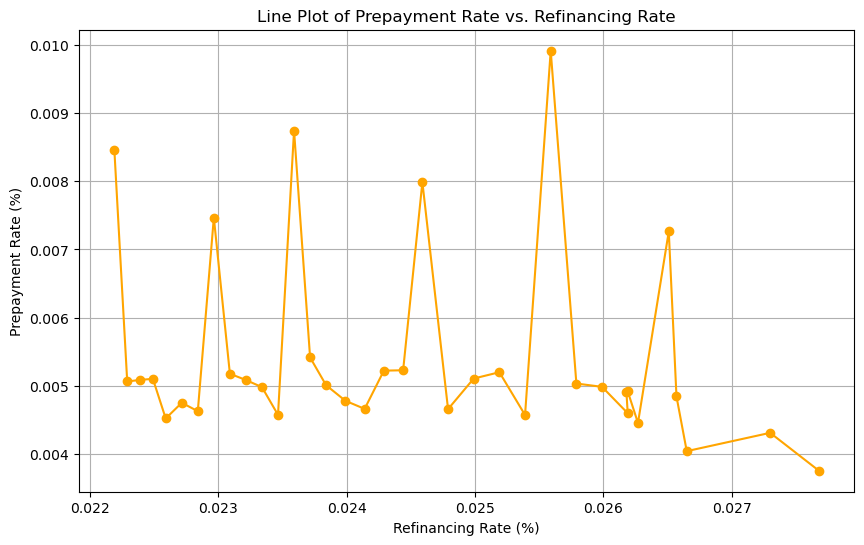

In [26]:
# Creating a line plot to show the relationship between prepayment rate and refinancing rate over time
plt.figure(figsize=(10, 6))
plt.plot(monthly_refinancing_rate['Refinancing rate'], monthly_prepayment_rate['PP_rate (%)'], marker='o', linestyle='-', color='orange')
plt.xlabel('Refinancing Rate (%)')
plt.ylabel('Prepayment Rate (%)')
plt.title('Line Plot of Prepayment Rate vs. Refinancing Rate')
plt.grid(True)
plt.show()

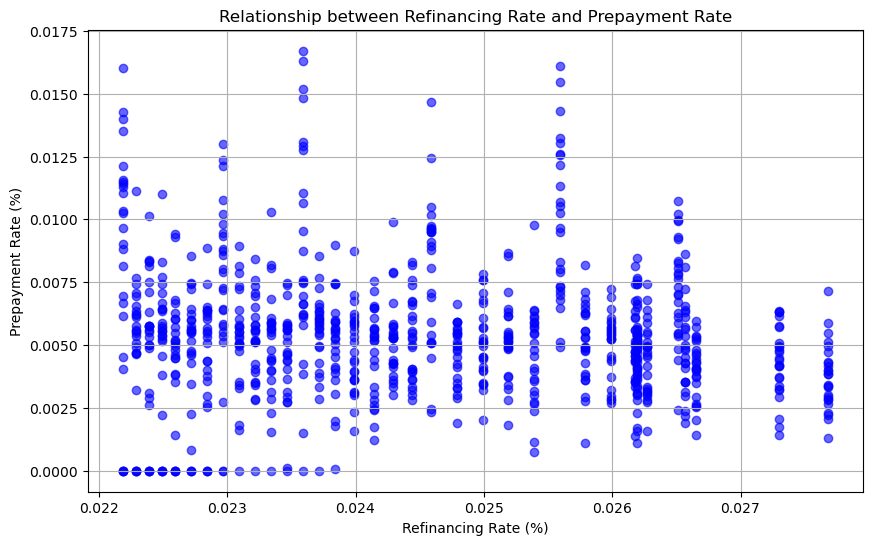

In [27]:
# Creating a scatter plot to show the relationship between "Client Rate - Refinancing Rate" and "Prepayment Rate (%)"

plt.figure(figsize=(10, 6))
plt.scatter(df['Refinancing rate'], df['PP_rate (%)'], alpha=0.6, color='blue')
plt.xlabel('Refinancing Rate (%)')
plt.ylabel('Prepayment Rate (%)')
plt.title('Relationship between Refinancing Rate and Prepayment Rate')
plt.grid(True)
plt.show()

## First Modeling 

Using just refinancing rate

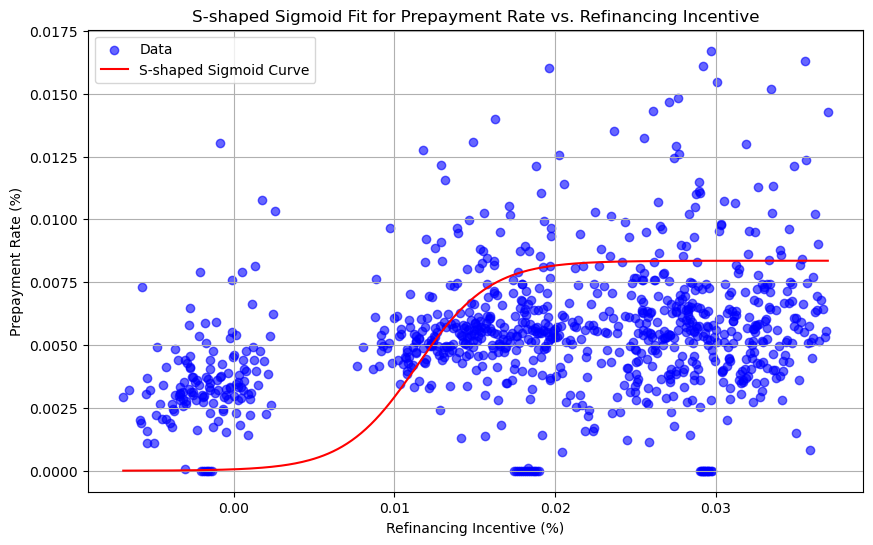

Optimized Parameters:
L = 0.5000000000000001
x0 = -0.6742927885174409
k = 5.000000000000001
b = 7.221103506410652e-31


In [28]:
# Extract the independent (X) and dependent (Y) variables
X = df['Refinancing Incentive'].values
Y = df['PP_rate (%)'].values

# Normalize the Y values to a range between 0 and 1 for better stability
Y_norm = (Y - min(Y)) / (max(Y) - min(Y))

# Normalize the X values for better stability
X_norm = (X - np.mean(X)) / np.std(X)

# Define the sigmoid (logistic) function
def sigmoid(x, L, x0, k, b):
    """
    Sigmoid function.
    L : Maximum value of the curve (upper asymptote)
    x0: The x-value of the sigmoid's midpoint
    k : The steepness of the curve
    b : The baseline (lower asymptote)
    """
    return L / (1 + np.exp(-k * (x - x0))) + b

# Initial guess for the parameters (L, x0, k, b) and bounds to ensure a proper S-shape
initial_guess = [1, 0, 20, 0]  # L = 1 (normalized), x0 = 0 (centered X), k = 20 (steep), b = 0 (baseline)
bounds = ([0.5, -2, 5, 0], [1.5, 2, 100, 0.5])

# Fit the sigmoid curve with the normalized X and Y values
popt, _ = curve_fit(sigmoid, X_norm, Y_norm, p0=initial_guess, bounds=bounds, maxfev=50000)

# Generate x-values for the fitted curve and denormalize the X values for plotting
x_range = np.linspace(min(X), max(X), 300)
L, x0, k, b = popt
fitted_curve = sigmoid((x_range - np.mean(X)) / np.std(X), L, x0, k, b) * (max(Y) - min(Y)) + min(Y)

# Plot the data and the fitted sigmoid curve
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, alpha=0.6, color='blue', label='Data')
plt.plot(x_range, fitted_curve, color='red', label='S-shaped Sigmoid Curve')
plt.xlabel('Refinancing Incentive (%)')
plt.ylabel('Prepayment Rate (%)')
plt.title('S-shaped Sigmoid Fit for Prepayment Rate vs. Refinancing Incentive')
plt.grid(True)
plt.legend()
plt.show()

# Display the optimized parameters of the improved sigmoid function
print(f"Optimized Parameters:\nL = {L}\nx0 = {x0}\nk = {k}\nb = {b}")


## Second Model

Adding seasonal variables

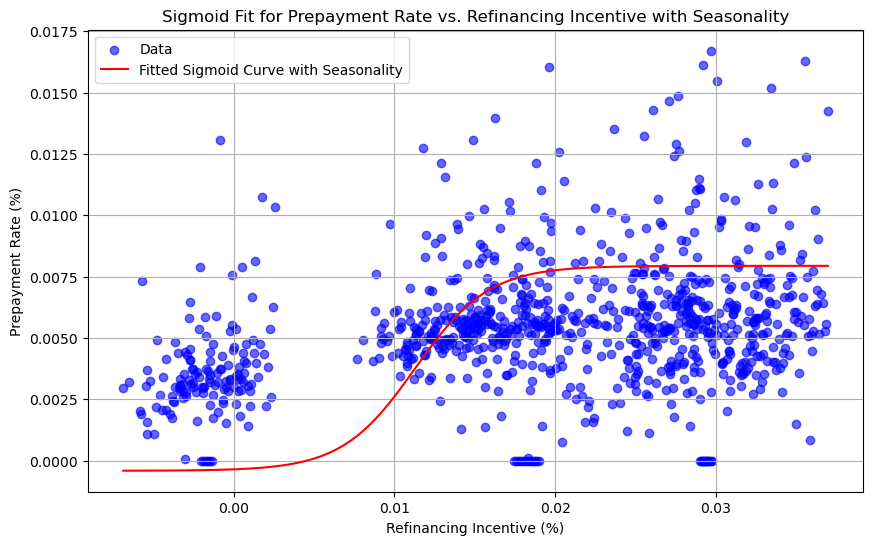

Optimized Parameters:
L = 0.5000000000000001
x0 = -0.6842679130757864
k = 5.000000000000001
b = 1.2959911569524367e-29


In [29]:


# Adding seasonality indicators by extracting the month and quarter from the 'Date' column
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter

# One-hot encoding the month and quarter to create dummy variables (categorical features)
month_dummies = pd.get_dummies(df['Month'], prefix='Month', drop_first=True)
quarter_dummies = pd.get_dummies(df['Quarter'], prefix='Quarter', drop_first=True)

# Adding the dummies to the DataFrame
df = pd.concat([df, month_dummies, quarter_dummies], axis=1)

# Extracting the independent (X) and dependent (Y) variables
# Including the 'Refinancing Incentive' along with the seasonal indicators (months and quarters)
seasonal_features = ['Refinancing Incentive'] + list(month_dummies.columns) + list(quarter_dummies.columns)
X = df[seasonal_features].values
Y = df['PP_rate (%)'].values

# Normalize the Y values to a range between 0 and 1 for better stability
Y_norm = (Y - min(Y)) / (max(Y) - min(Y))

# Normalize the X values for better stability
X_norm = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Define the sigmoid function to include the main feature (Refinancing Incentive) and seasonal effects
def sigmoid_with_seasonality_full(x, L, x0, k, b, *seasonal_params):
    """
    Sigmoid function that includes the main feature (Refinancing Incentive) and seasonal effects.
    L : Maximum value of the curve (upper asymptote)
    x0: The x-value of the sigmoid's midpoint
    k : The steepness of the curve
    b : The baseline (lower asymptote)
    seasonal_params : Coefficients for the seasonal dummy variables
    """
    # Sigmoid component
    sigmoid_part = L / (1 + np.exp(-k * (x[:, 0] - x0))) + b
    
    # Add the influence of the seasonal dummy variables
    seasonality_effect = np.dot(x[:, 1:], seasonal_params)
    return sigmoid_part + seasonality_effect

# Initial guess for the parameters (L, x0, k, b) and additional parameters for each seasonal dummy
initial_guess = [1, 0, 20, 0] + [0] * (X.shape[1] - 1)  # Initial guess for the seasonal effects is 0
bounds = ([0.5, -2, 5, 0] + [-5] * (X.shape[1] - 1), [1.5, 2, 100, 5] + [5] * (X.shape[1] - 1))

# Fit the sigmoid curve using 'Refinancing Incentive' and seasonal features
popt, _ = curve_fit(lambda x, *params: sigmoid_with_seasonality_full(x, *params), X_norm, Y_norm, 
                    p0=initial_guess, bounds=bounds, maxfev=50000)

# Generate x-values for the fitted curve (use mean values for seasonal effects)
x_range = np.linspace(min(X[:, 0]), max(X[:, 0]), 300)
x_range_normalized = ((x_range - np.mean(X[:, 0])) / np.std(X[:, 0])).reshape(-1, 1)

# Calculate the mean of the seasonal dummy variables
seasonal_means = np.mean(X[:, 1:], axis=0)

# Repeat the seasonal means to match the length of x_range
seasonal_repeated = np.tile(seasonal_means, (len(x_range), 1))

# Combine the transformed 'Refinancing Incentive' values with the seasonal means
X_combined_range = np.hstack((x_range_normalized, seasonal_repeated))

# Compute the fitted curve
fitted_curve = sigmoid_with_seasonality_full(X_combined_range, *popt) * (max(Y) - min(Y)) + min(Y)

# Plot the data and the fitted sigmoid curve with seasonality
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], Y, alpha=0.6, color='blue', label='Data')
plt.plot(x_range, fitted_curve, color='red', label='Fitted Sigmoid Curve with Seasonality')
plt.xlabel('Refinancing Incentive (%)')
plt.ylabel('Prepayment Rate (%)')
plt.title('Sigmoid Fit for Prepayment Rate vs. Refinancing Incentive with Seasonality')
plt.grid(True)
plt.legend()
plt.show()

# Display the optimized parameters of the sigmoid function
print(f"Optimized Parameters:\nL = {popt[0]}\nx0 = {popt[1]}\nk = {popt[2]}\nb = {popt[3]}")


# Third model 

Extended with other explanatory variables

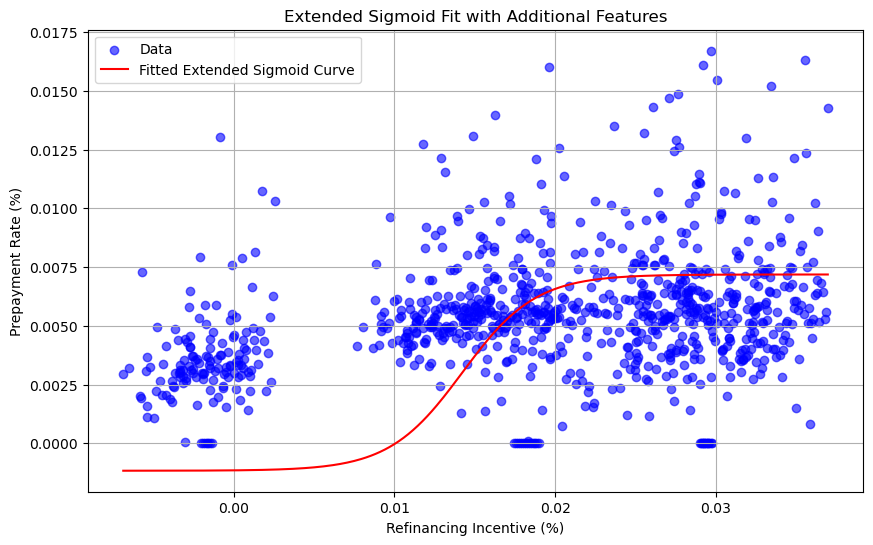

Optimized Parameters:
L = 0.5000000000000001
x0 = -0.427264778845342
k = 5.000000000000001
b = 6.800647995645445e-24


In [30]:

# Convert loan start and end dates to datetime
df['Loan_start_date'] = pd.to_datetime(df['Loan_start_date'], errors='coerce')
df['Loan_end_date'] = pd.to_datetime(df['Loan_end_date'], errors='coerce')

# Calculate loan age in years
current_date = datetime.now()
df['Loan_age_years'] = (current_date - df['Loan_start_date']).dt.days / 365.25

# Normalize and standardize the new features
additional_features = ['Remaining_maturity (M)', 'Outstanding_notional', 'Starting_notional', 'Loan_age_years']
for feature in additional_features:
    df[feature] = (df[feature] - df[feature].mean()) / df[feature].std()

# Adding seasonality indicators by extracting the month and quarter from the 'Date' column
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter

# One-hot encoding the month and quarter to create dummy variables (categorical features)
month_dummies = pd.get_dummies(df['Month'], prefix='Month', drop_first=True)
quarter_dummies = pd.get_dummies(df['Quarter'], prefix='Quarter', drop_first=True)

# Add the dummies back into the DataFrame
df = pd.concat([df, month_dummies, quarter_dummies], axis=1)

# Update the list of features to include these new explanatory variables along with 'Refinancing Incentive' and seasonality
extended_features = ['Refinancing Incentive'] + additional_features + list(month_dummies.columns) + list(quarter_dummies.columns)
X = df[extended_features].values
Y = df['PP_rate (%)'].values

# Normalize the Y values
Y_norm = (Y - min(Y)) / (max(Y) - min(Y))

# Normalize the X values
X_norm = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Define the sigmoid function to include all these new features as parameters
def extended_sigmoid_with_features(x, L, x0, k, b, *params):
    """
    Sigmoid function that includes the main feature (Refinancing Incentive) and additional explanatory variables.
    L : Maximum value of the curve (upper asymptote)
    x0: The x-value of the sigmoid's midpoint
    k : The steepness of the curve
    b : The baseline (lower asymptote)
    params : Coefficients for the additional features (remaining maturity, outstanding notional, etc.)
    """
    sigmoid_part = L / (1 + np.exp(-k * (x[:, 0] - x0))) + b
    additional_effects = np.dot(x[:, 1:], params)
    return sigmoid_part + additional_effects

# Set up initial guesses and bounds for the parameters
initial_guess = [1, 0, 20, 0] + [0] * (X.shape[1] - 1)
bounds = ([0.5, -2, 5, 0] + [-5] * (X.shape[1] - 1), [1.5, 2, 100, 5] + [5] * (X.shape[1] - 1))

# Fit the extended model using the additional features
popt, _ = curve_fit(lambda x, *params: extended_sigmoid_with_features(x, *params), X_norm, Y_norm, 
                    p0=initial_guess, bounds=bounds, maxfev=50000)

# Generate x-values for the fitted curve (keeping additional features constant at their means)
x_range = np.linspace(min(X[:, 0]), max(X[:, 0]), 300)
x_range_normalized = ((x_range - np.mean(X[:, 0])) / np.std(X[:, 0])).reshape(-1, 1)
additional_means = np.mean(X[:, 1:], axis=0)
repeated_means = np.tile(additional_means, (len(x_range), 1))
X_combined_range = np.hstack((x_range_normalized, repeated_means))

# Compute the fitted curve
fitted_curve = extended_sigmoid_with_features(X_combined_range, *popt) * (max(Y) - min(Y)) + min(Y)

# Plot the data and the fitted extended sigmoid curve
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], Y, alpha=0.6, color='blue', label='Data')
plt.plot(x_range, fitted_curve, color='red', label='Fitted Extended Sigmoid Curve')
plt.xlabel('Refinancing Incentive (%)')
plt.ylabel('Prepayment Rate (%)')
plt.title('Extended Sigmoid Fit with Additional Features')
plt.grid(True)
plt.legend()
plt.show()

# Display the optimized parameters of the extended model
print(f"Optimized Parameters:\nL = {popt[0]}\nx0 = {popt[1]}\nk = {popt[2]}\nb = {popt[3]}")


# Fourth model

Using May and December variables


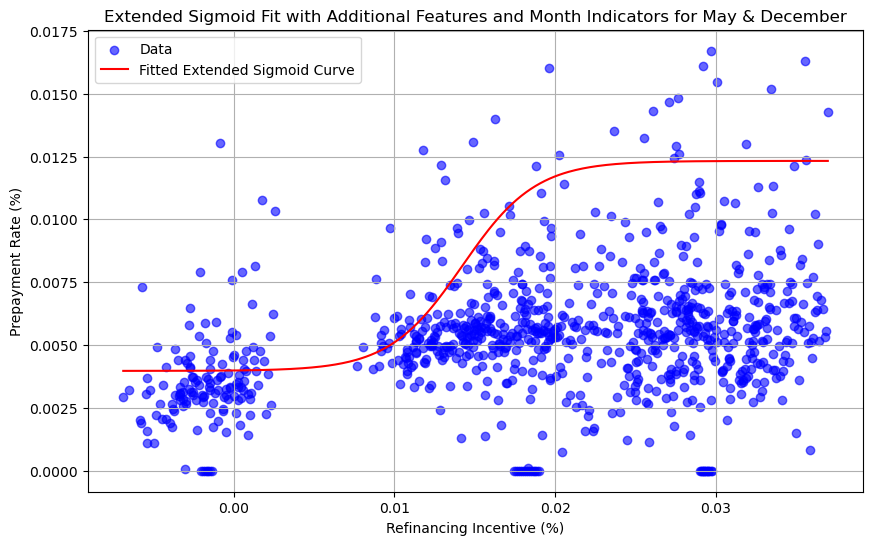

Optimized Parameters:
L = 0.5000000000000001
x0 = -0.4272684883783427
k = 5.000000000000001
b = 3.635869452707955e-26


In [31]:
# Add indicator variables for May and December
df['Is_May'] = (df['Month'] == 5).astype(int)
df['Is_December'] = (df['Month'] == 12).astype(int)

# Add the dummies and indicator variables back into the DataFrame
df = pd.concat([df, month_dummies, quarter_dummies], axis=1)

# Update the list of features to include these new indicators along with the other explanatory variables
extended_features = ['Refinancing Incentive'] + additional_features + ['Is_May', 'Is_December'] + list(month_dummies.columns) + list(quarter_dummies.columns)
X = df[extended_features].values
Y = df['PP_rate (%)'].values

# Normalize the Y values
Y_norm = (Y - min(Y)) / (max(Y) - min(Y))

# Normalize the X values
X_norm = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Define the sigmoid function to include all these new features as parameters
def extended_sigmoid_with_features2(x, L, x0, k, b, *params):
    """
    Sigmoid function that includes the main feature (Refinancing Incentive) and additional explanatory variables.
    L : Maximum value of the curve (upper asymptote)
    x0: The x-value of the sigmoid's midpoint
    k : The steepness of the curve
    b : The baseline (lower asymptote)
    params : Coefficients for the additional features (remaining maturity, outstanding notional, etc.)
    """
    sigmoid_part = L / (1 + np.exp(-k * (x[:, 0] - x0))) + b
    additional_effects = np.dot(x[:, 1:], params)
    return sigmoid_part + additional_effects

# Set up initial guesses and bounds for the parameters
initial_guess = [1, 0, 20, 0] + [0] * (X.shape[1] - 1)
bounds = ([0.5, -2, 5, 0] + [-5] * (X.shape[1] - 1), [1.5, 2, 100, 5] + [5] * (X.shape[1] - 1))

# Fit the extended model using the additional features, including the new indicators
popt, _ = curve_fit(lambda x, *params: extended_sigmoid_with_features2(x, *params), X_norm, Y_norm, 
                    p0=initial_guess, bounds=bounds, maxfev=50000)

# Generate x-values for the fitted curve (keeping additional features constant at their means)
x_range = np.linspace(min(X[:, 0]), max(X[:, 0]), 300)
x_range_normalized = ((x_range - np.mean(X[:, 0])) / np.std(X[:, 0])).reshape(-1, 1)
additional_means = np.mean(X[:, 1:], axis=0)
repeated_means = np.tile(additional_means, (len(x_range), 1))
X_combined_range = np.hstack((x_range_normalized, repeated_means))

# Compute the fitted curve
fitted_curve = extended_sigmoid_with_features2(X_combined_range, *popt) * (max(Y) - min(Y)) + min(Y)

# Plot the data and the fitted extended sigmoid curve
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], Y, alpha=0.6, color='blue', label='Data')
plt.plot(x_range, fitted_curve, color='red', label='Fitted Extended Sigmoid Curve')
plt.xlabel('Refinancing Incentive (%)')
plt.ylabel('Prepayment Rate (%)')
plt.title('Extended Sigmoid Fit with Additional Features and Month Indicators for May & December')
plt.grid(True)
plt.legend()
plt.show()

# Display the optimized parameters of the extended model
print(f"Optimized Parameters:\nL = {popt[0]}\nx0 = {popt[1]}\nk = {popt[2]}\nb = {popt[3]}")